In [2]:
from time import time
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scanpy as sc
from bbknn import bbknn
import scanorama as scr
import pandas as pd
from harmony import harmonize
from sklearn.metrics.cluster import adjusted_rand_score
import random
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import warnings

warnings.filterwarnings('ignore')

from matplotlib.colors import ListedColormap
import seaborn as sn

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.set_figure_params(dpi=50)

scanpy==1.6.0 anndata==0.7.4 umap==0.3.10 numpy==1.17.2 scipy==1.5.2 pandas==1.1.0 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1 leidenalg==0.7.0


# P38_dr_glut

In [25]:
P38_glut = sc.read_h5ad('P38_dr_glut.h5ad')

In [26]:
P38_glut

AnnData object with n_obs × n_vars = 21855 × 20354
    obs: 'n_genes', 'percent_mito', 'n_counts', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'sample'
    var: 'gene_ids', 'feature_types', 'n_cells-P38_dr_1a', 'n_cells-P38_dr_1b', 'n_cells-P38_dr_2a', 'n_cells-P38_dr_2b', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    obsm: 'X_pca', 'X_umap'

Quick check to remove obviously useless cells that don't express layer markers.

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns["dendrogram_['leiden']"]`


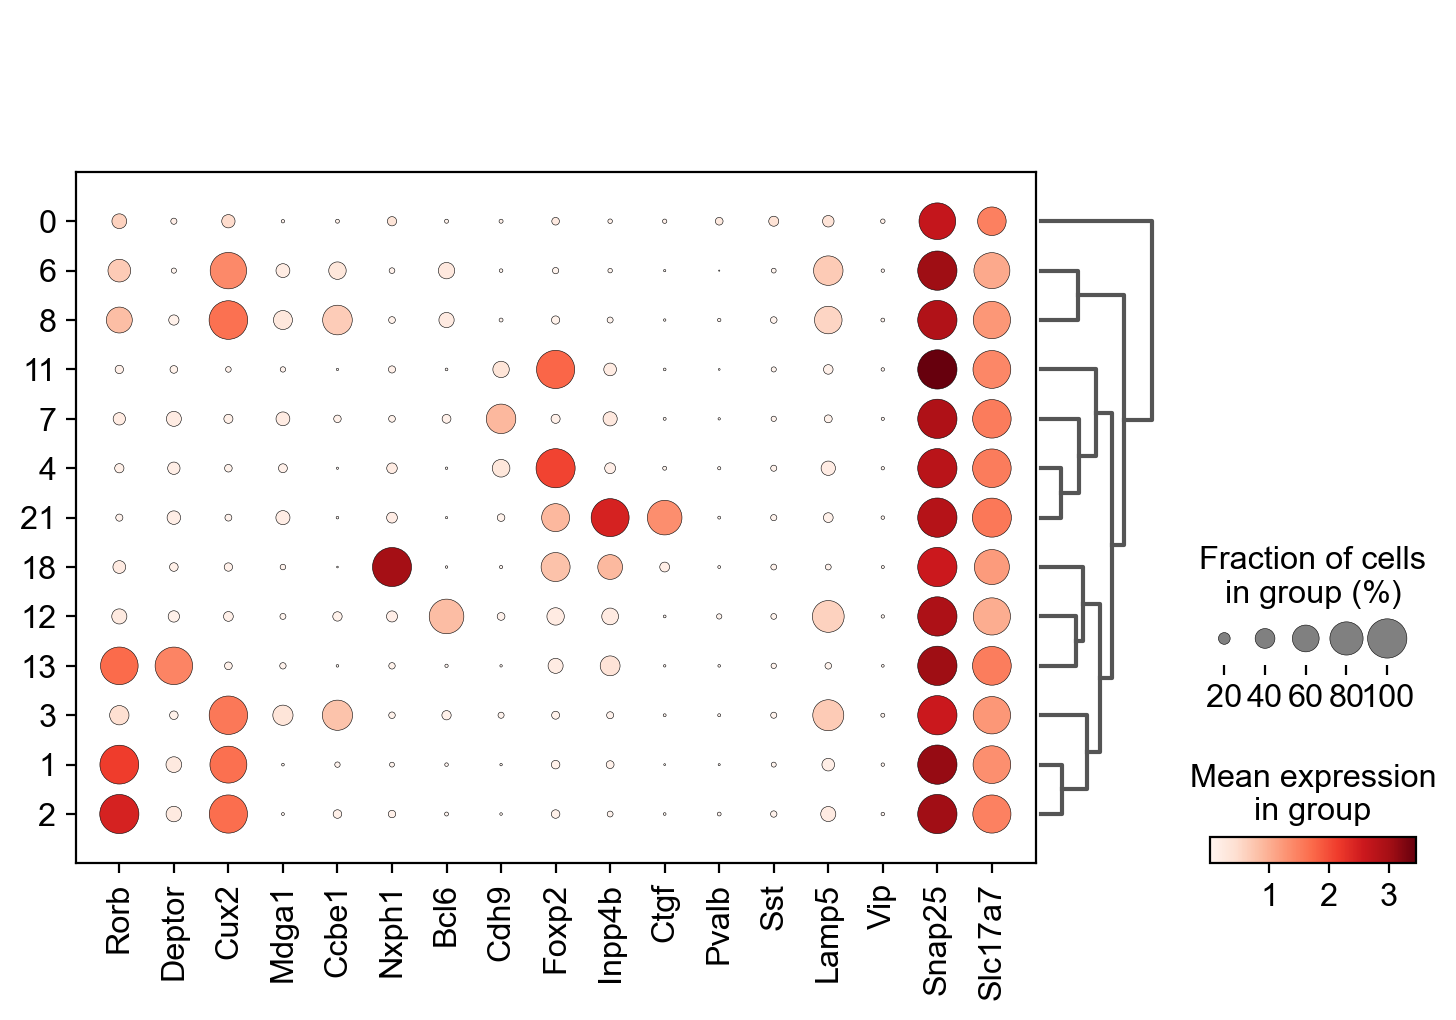

In [7]:
sc.pl.dotplot(P38_glut, ['Rorb', 'Deptor', 'Cux2', 'Mdga1', 'Ccbe1', 'Nxph1', 'Bcl6',
                'Cdh9', 'Foxp2', 'Inpp4b', 'Ctgf', 'Pvalb', 'Sst', 'Lamp5', 'Vip', 'Snap25', 'Slc17a7'], 
              groupby='leiden', dendrogram=True)

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


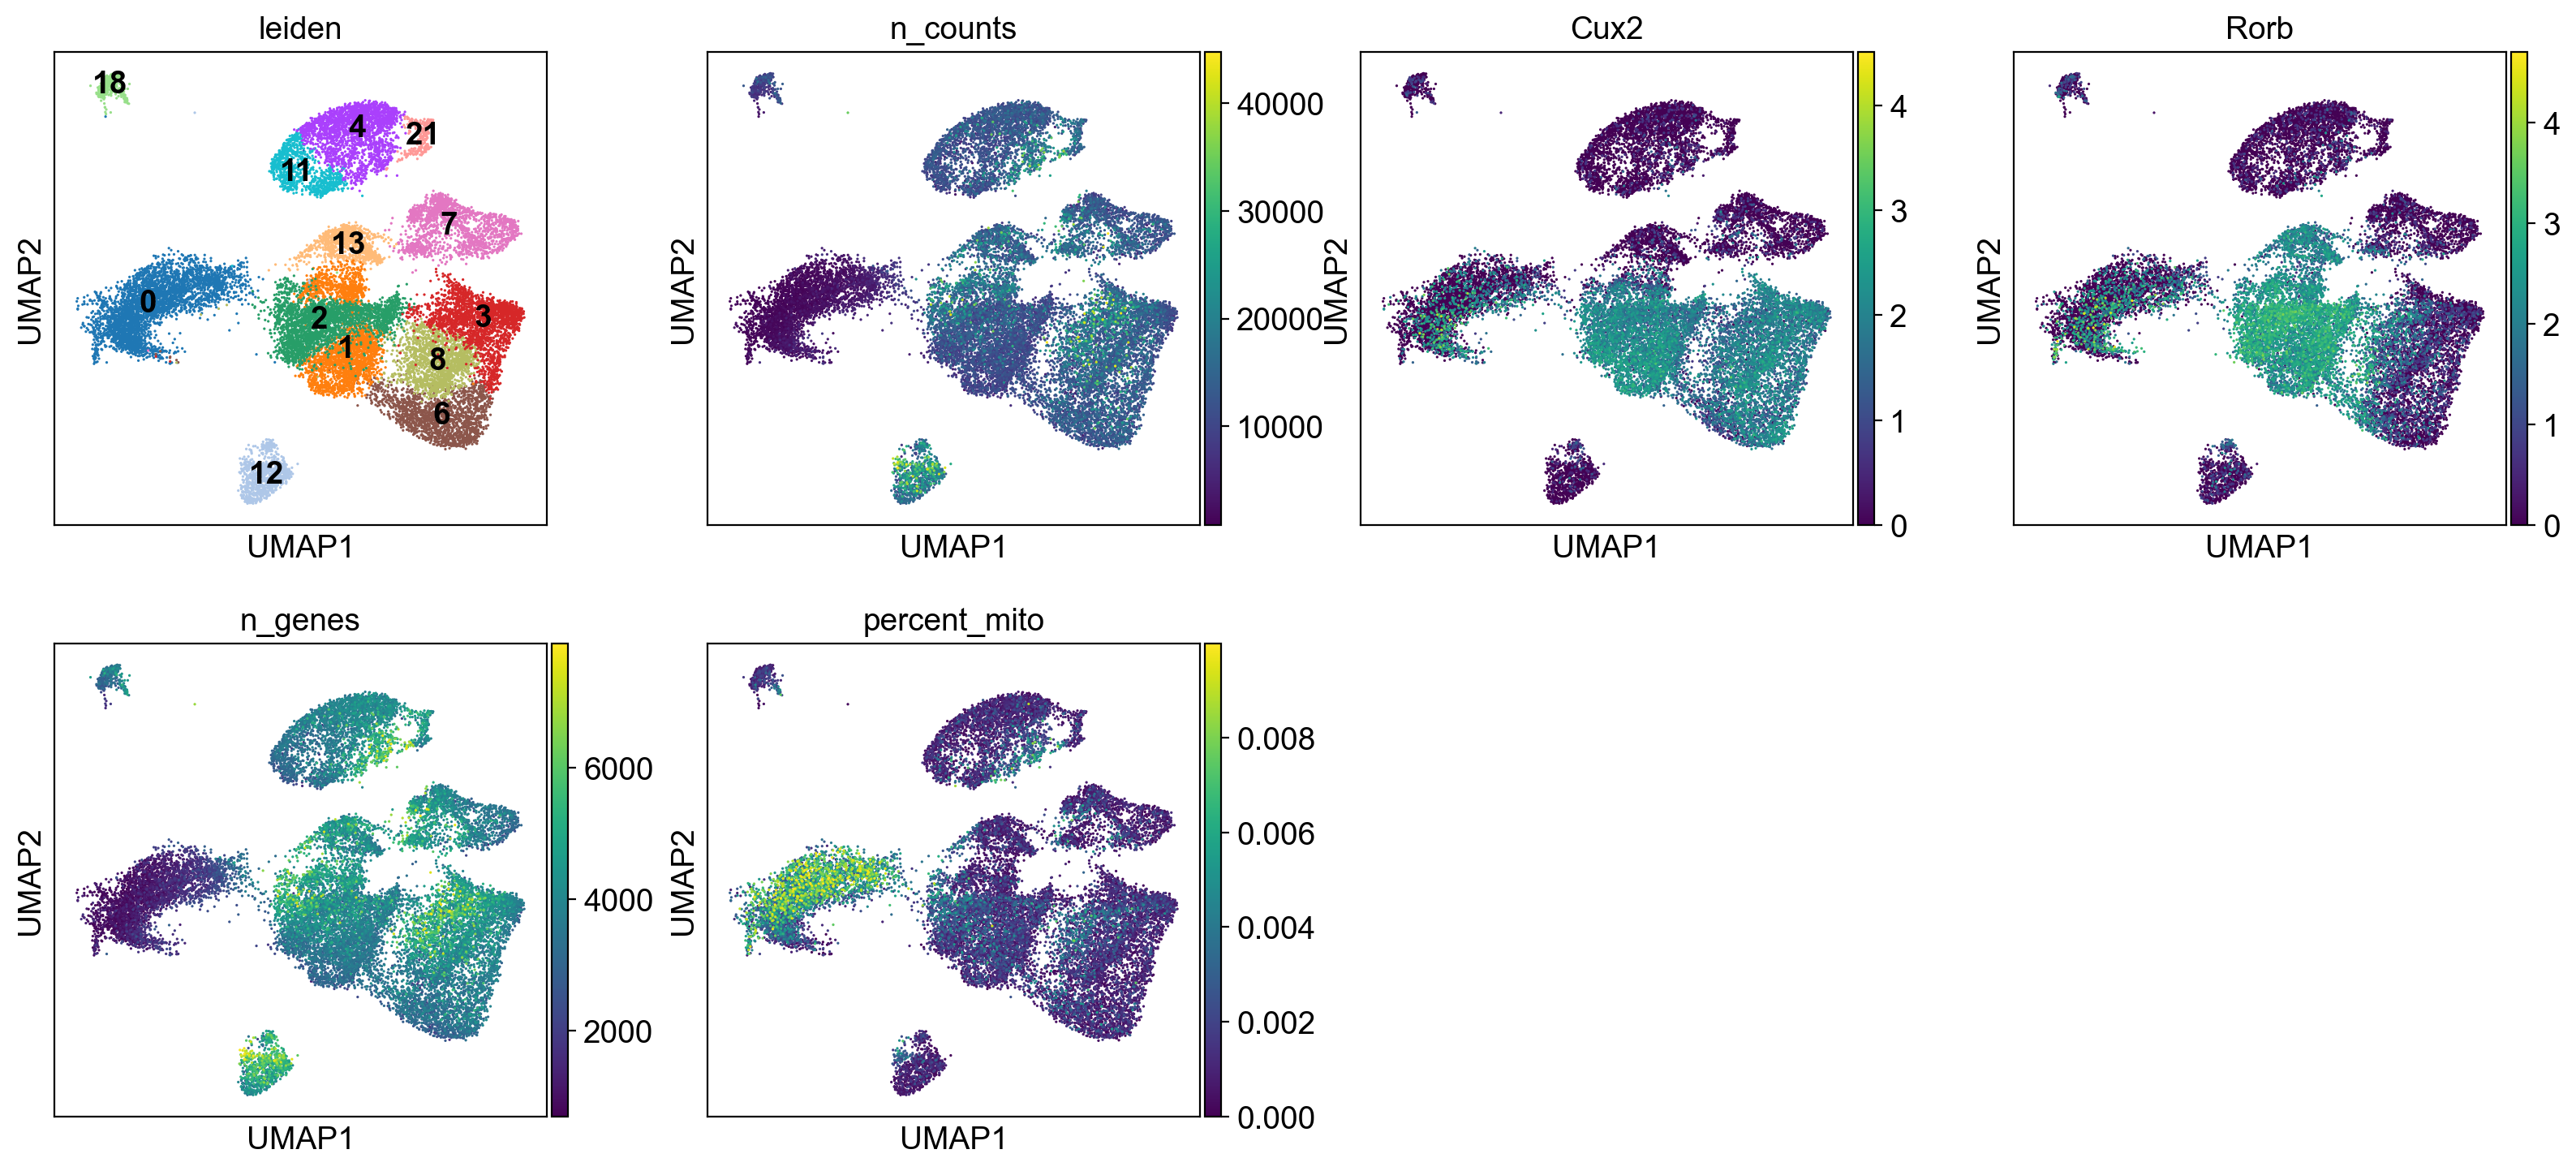

In [8]:
sc.pl.umap(P38_glut, color=['leiden', 'n_counts', 'Cux2', 'Rorb', 
                            'n_genes', 'percent_mito'], legend_loc='on data')

In [27]:
P38_glut = P38_glut[P38_glut.obs['leiden']!='0',:]

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [28]:
P38_glut

View of AnnData object with n_obs × n_vars = 18111 × 20354
    obs: 'n_genes', 'percent_mito', 'n_counts', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'sample'
    var: 'gene_ids', 'feature_types', 'n_cells-P38_dr_1a', 'n_cells-P38_dr_1b', 'n_cells-P38_dr_2a', 'n_cells-P38_dr_2b', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    obsm: 'X_pca', 'X_umap'

In [29]:
del P38_glut.obsp
del P38_glut.varm
del P38_glut.obsm
del P38_glut.uns
for i in ['n_cells-P38_dr_1a', 'n_cells-P38_dr_1b', 'n_cells-P38_dr_2a', 
          'n_cells-P38_dr_2b', 'highly_variable', 'means', 'dispersions', 
          'dispersions_norm', 'mean', 'std']: del P38_glut.var[i]
P38_glut

AnnData object with n_obs × n_vars = 18111 × 20354
    obs: 'n_genes', 'percent_mito', 'n_counts', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'sample'
    var: 'gene_ids', 'feature_types'

In [35]:
P38_glut.X = P38_glut.raw.X.A
sc.pp.highly_variable_genes(P38_glut, min_mean=0.0125, max_mean=3, min_disp=0.5) #HVGs

sc.pp.scale(P38_glut, max_value=10) #scale
sc.tl.pca(P38_glut, svd_solver='arpack') #run PCA

Z = harmonize(P38_glut.obsm['X_pca'], P38_glut.obs, batch_key = 'sample')
P38_glut.obsm['X_harmony'] = Z

sc.pp.neighbors(P38_glut, n_neighbors=25, use_rep='X_harmony')

#sc.pp.neighbors(P38_glut, n_neighbors=25)
#bbknn(P38_glut, batch_key='sample',neighbors_within_batch =6 ) #doesn't work
#sc.tl.leiden(P38_glut)
sc.tl.umap(P38_glut)

extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:04)
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
	Completed 10 / 10 iteration(s).
computing neighbors


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../opt/anaconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:15)


P38_glut = P38_glut[P38_glut.obs['leiden']!='14',:]
P38_glut = P38_glut[P38_glut.obs['leiden']!='16',:]
P38_glut = P38_glut[P38_glut.obs['leiden']!='17',:]
P38_glut = P38_glut[P38_glut.obs['leiden']!='19',:]

In [ ]:
#P38_glut = sc.read_h5ad('P38_glut_dr_harmony_112920.h5ad')

In [4]:
P38_glut = sc.read_h5ad('P38_glut_dr_harmony_120120.h5ad')

Storing dendrogram info using `.uns["dendrogram_['leiden']"]`


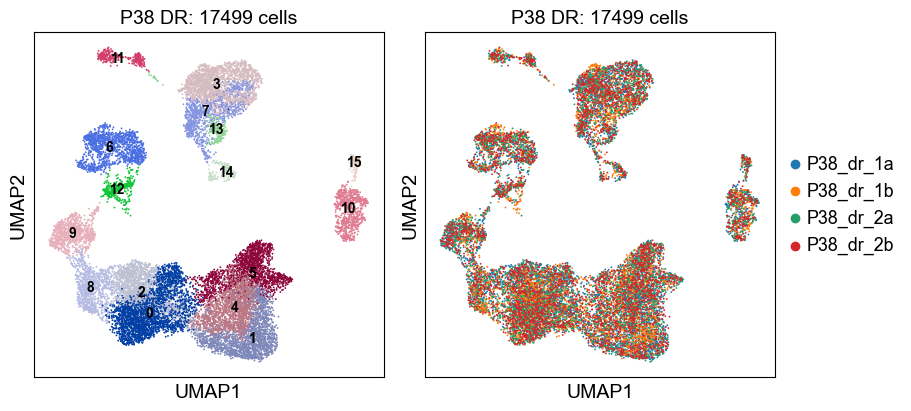

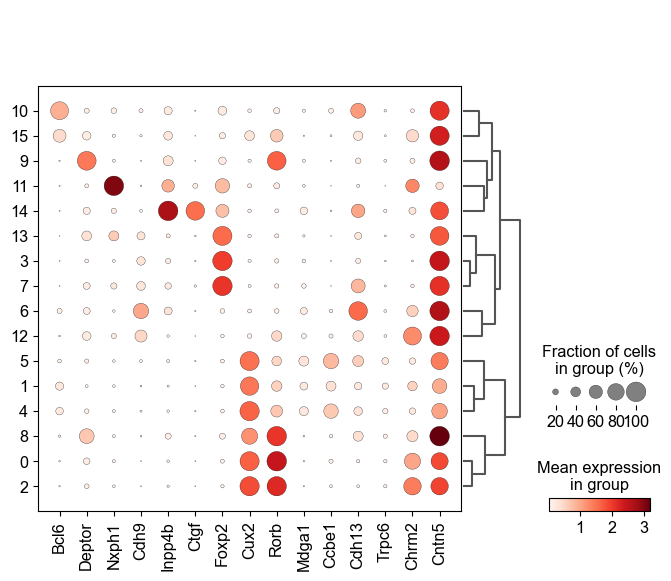

In [22]:
#sc.tl.leiden(P38_glut, resolution=0.87) #0.87 is best-- requires no merging
fig, axs = plt.subplots(1, 2, figsize = (9,4), constrained_layout=True)
sc.pl.umap(P38_glut, color='leiden', legend_fontsize='10', ax=axs[0], 
           show=False, title='P38 DR: ' + str(P38_glut.shape[0]) + ' cells', frameon=True, legend_loc='on data')
#c.pl.umap(P38_glut, color='leiden', ax=axs[1], show=False, title='P38 DR Leiden: ' + str(P38_glut.uns['leiden']['params']['resolution']) + ' res', legend_loc='on data')
sc.pl.umap(P38_glut, color='sample', ax=axs[1], show=False, title='P38 DR: ' + str(P38_glut.shape[0]) + ' cells')
#sc.pl.umap(P38_glut, color='layer', ax=axs[3], show=False, title='P38 DR: ' + str(P38_glut.shape[0]) + ' cells')

bias_markers = [ 'Bcl6', 'Deptor',
                 'Nxph1', 'Cdh9',  'Inpp4b', 'Ctgf',  'Foxp2', 
                 'Cux2', 'Rorb','Mdga1', 'Ccbe1', 'Cdh13', 'Trpc6', 'Chrm2', 'Cntn5']
sc.tl.dendrogram(P38_glut, groupby='leiden', use_rep='X_harmony')
sc.pl.dotplot(P38_glut, bias_markers, groupby='leiden', dendrogram=True)

## Merge and name clusters

Name L5 and L6 clusters based on their mapping to NR names. Name L2/3/4 as Subclass_#.

5 and 11 merge for L2/3

In [21]:
P38_glut.obs.leiden.values.categories

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15'],
      dtype='object')

In [5]:
Type = ['L4_1', 'L2/3_3', 'L4_2', 'L6CT_B', 'L2/3_2', 'L2/3_1',
        'L6IT_A', 'L6CT_C', 'L4_C', 'L5IT',
        'L5PT_A', 'L5NP', 'L6IT_B', 'L6CT_A',
        'L6b', 'L5PT_B']

P38_glut.obs['Type'] = P38_glut.obs['leiden']
a = P38_glut.obs['Type']
P38_glut.obs['Type'] = a.cat.rename_categories(Type).values
#P38_glut.rename_categories(key='Type', categories=[Type])

In [10]:
P38_glut.uns['leiden']

{'params': {'n_iterations': -1, 'random_state': 0, 'resolution': 0.87}}

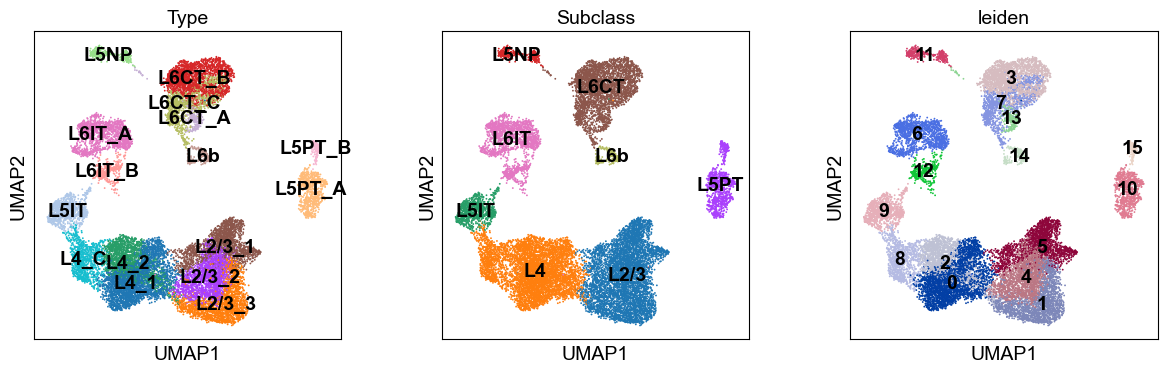

In [8]:
sc.pl.umap(P38_glut, color=['Type','Subclass', 'leiden'], legend_loc='on data')

P38_glut.obs['Type'] = P38_glut.obs['leiden']
P38_glut.obs['Type'] = pd.Series(Type, dtype='category').values

`L2/3_1` here is a slight counterpart to 

Type = []

for i in range(P38_glut.shape[0]):
    if (P38_glut.obs['cluster'][i] in ['5', '11']): 
        Type.append('L2/3_1') 
    
    else: Type.append(P38_glut.obs['cluster'][i])

sc.pl.umap(P38_glut, color=['leiden', 'cluster', 'Type'], legend_loc='on data', legend_fontsize='10')

<AxesSubplot:title={'center':'P38 DR: 17499 cells'}, xlabel='UMAP1', ylabel='UMAP2'>

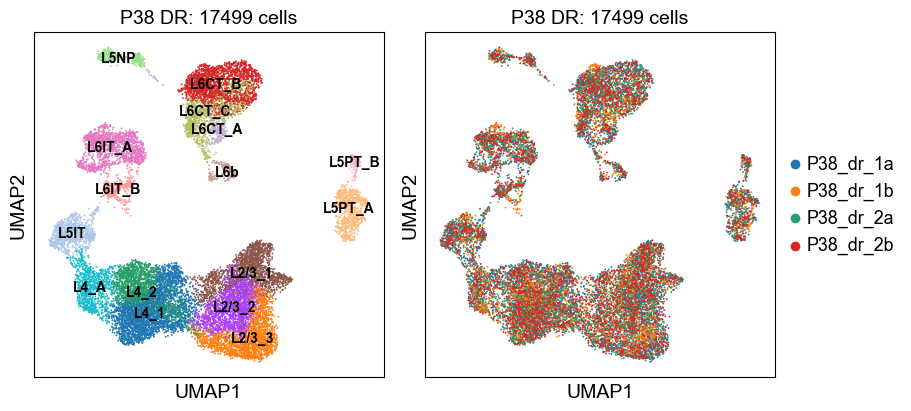

In [24]:
fig, axs = plt.subplots(1, 2, figsize = (9,4), constrained_layout=True)
sc.pl.umap(P38_glut, color='Type', legend_fontsize='10', ax=axs[0], 
           show=False, title='P38 DR: ' + str(P38_glut.shape[0]) + ' cells', frameon=True, legend_loc='on data')
#c.pl.umap(P38_glut, color='leiden', ax=axs[1], show=False, title='P38 DR Leiden: ' + str(P38_glut.uns['leiden']['params']['resolution']) + ' res', legend_loc='on data')
sc.pl.umap(P38_glut, color='sample', ax=axs[1], show=False, title='P38 DR: ' + str(P38_glut.shape[0]) + ' cells')
#sc.pl.umap(P38_glut, color='layer', ax=axs[3], show=False, title='P38 DR: ' + str(P38_glut.shape[0]) + ' cells')

fig, axs = plt.subplots(6, 3, figsize = (15,30), constrained_layout=True)

a = 0
b = 0
for i in P38_glut.uns["dendrogram_['leiden']"]['categories_ordered']:

    clust = P38_glut[P38_glut.obs.leiden==i, :]
    #print('Cluster', i)
    for j in clust.obs['sample'].values.categories:
        #print(j, clust[clust.obs['sample']==j,:].shape[0])
        axs[a,b].bar(j, clust[clust.obs['sample']==j,:].shape[0]/clust.shape[0])
    

    
    #print(' ')
    axs[a,b].set_ylabel('Fraction of cluster')
    axs[a,b].set_title('Cluster ' + str(i))
    axs[a,b].set_title('Cluster ' + str(i))
    axs[a,b].set_xticklabels(clust.obs['sample'].values.categories, rotation=45)

    
    b = b + 1
    
    if (b>2): 
        a = a + 1
        b = 0
        
plt.tight_layout()
fig.savefig('P38glut_dr_integration.pdf')

In [25]:
P38_glut.obs['Subclass'] = P38_glut.obs['Type']
P38_glut.obs['Subclass'] = P38_glut.obs['Subclass'].str.replace('_1','')
P38_glut.obs['Subclass'] = P38_glut.obs['Subclass'].str.replace('_2','')
P38_glut.obs['Subclass'] = P38_glut.obs['Subclass'].str.replace('_3','')
P38_glut.obs['Subclass'] = P38_glut.obs['Subclass'].str.replace('_A','')
P38_glut.obs['Subclass'] = P38_glut.obs['Subclass'].str.replace('_AB','')
P38_glut.obs['Subclass'] = P38_glut.obs['Subclass'].str.replace('_B','')
P38_glut.obs['Subclass'] = P38_glut.obs['Subclass'].str.replace('B','')
P38_glut.obs['Subclass'] = P38_glut.obs['Subclass'].str.replace('_C','')

... storing 'Subclass' as categorical


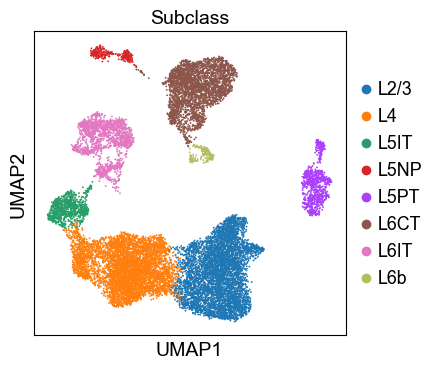

In [27]:
sc.pl.umap(P38_glut, color='Subclass')

# Write

In [11]:
#P38_glut.write_h5ad('P38_glut_dr_harmony_112920.h5ad')
#P38_glut.write_h5ad('P38_glut_dr_harmony_120120.h5ad')
P38_glut.write_h5ad('P38_glut_dr_harmony_041221.h5ad')